## Initial Tasks

Import necessary modules...

In [90]:
import warnings
from typing import Any, Tuple

import pandas as pd
import numpy as np
import optuna

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, RocCurveDisplay,
    PrecisionRecallDisplay
)
from sklearn.base import clone
from sklearn.model_selection import cross_validate

Load the dataset...

In [2]:
dataset = pd.read_csv("processed_titanic_dataset.csv")

Although already preprocessed, take a quick look at the given data.

In [3]:
dataset

,Survived,Age,Pclass:1,Pclass:2,Pclass:3,Sex:female,Sex:male,Embarked:C,Embarked:Q,Embarked:S,SibSp:0,SibSp:1,SibSp:2,SibSp:3,SibSp:gte4,Parch:0,Parch:1,Parch:2,Parch:gte3,LogFare
0,0,-0.589288,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,0,0,-0.877097
1,1,0.644485,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1.365611
2,1,-0.280845,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,-0.795833
3,1,0.413153,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1.066196
4,0,0.413153,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,0,0,-0.781461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
884,0,-0.203734,0,1,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,-0.330629
885,1,-0.820621,1,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0.490792
886,0,0.000000,0,0,1,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0.245525
887,1,-0.280845,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0.490792


## Train / Validation / Test Split

Extract numpy arrays from the DataFrames...

In [4]:
x_all = dataset.drop(columns=["Survived", ]).values
y_all = dataset["Survived"].values

Examine shapes...

In [5]:
print(f"X shape: {x_all.shape}, y shape: {y_all.shape}")

X shape: (889, 19), y shape: (889,)


Create the train, validation and test splits...

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=0.1, random_state=1994)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=1994)

Examine shapes...

In [7]:
print(f"X train shape: {x_train.shape}, y train shape: {y_train.shape}")
print(f"X valid shape: {x_valid.shape}, y valid shape: {y_valid.shape}")
print(f"X test shape: {x_test.shape}, y test shape: {y_test.shape}")

X train shape: (640, 19), y train shape: (640,)
X valid shape: (160, 19), y valid shape: (160,)
X test shape: (89, 19), y test shape: (89,)


## Address Class Imbalance

Create a class weighting dictionary based on the occurrence of the different survival rates...

In [8]:
class_weight = 1 / dataset["Survived"].value_counts()
class_weight = class_weight / np.sum(class_weight)
class_weight = {class_idx: class_value for class_idx, class_value in enumerate(class_weight.values)}
class_weight

{0: np.float64(0.38245219347581555), 1: np.float64(0.6175478065241845)}

## Optuna Setup

Ignore optuna warnings...

In [9]:
optuna.logging.set_verbosity(optuna.logging.ERROR)

Define a universal classifier evaluation function...

In [10]:
def calculate_score(classifier: Any) -> float:

    classifier.fit(x_train, y_train)
    y_valid_pred = classifier.predict(x_valid)
    return accuracy_score(y_valid, y_valid_pred)

Test the defined function on an arbitrary classifier...

In [11]:
calculate_score(LogisticRegression())

0.78125

Define an objective function for the LogisticRegression class...

In [12]:
def lr_objective(trial: optuna.Trial) -> float:
    
    penalty = trial.suggest_categorical(
        "lr_penalty", ["None", "l1", "l2", "elasticnet"]
    )

    if penalty == "None":
        penalty = None
        inverse_regularization_strength = 1.0
        solver = "lbfgs"
        l1_ratio = None
    elif penalty == "l1":
        inverse_regularization_strength = trial.suggest_float("lr_l1_C", 1E-3, 1E3, log=True)
        solver = "liblinear"
        l1_ratio = None
    elif penalty == "l2":
        inverse_regularization_strength = trial.suggest_float("lr_l2_C", 1E-3, 1E3, log=True)
        solver = "lbfgs"
        l1_ratio = None
    elif penalty == "elasticnet":
        inverse_regularization_strength = trial.suggest_float("lr_elasticnet_C", 1E-3, 1E3, log=True)
        solver = "saga"
        l1_ratio = trial.suggest_float("lr_elasticnet_l1_ratio", 0.001, 0.999, log=False)
    else:
        raise Exception("Unreachable!")
        
    classifier = LogisticRegression(
        penalty=penalty,
        C=inverse_regularization_strength,
        l1_ratio=l1_ratio,
        solver=solver,
        class_weight=class_weight
    )
    return calculate_score(classifier)

Run a short mock study using the defined objective...

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study = optuna.create_study(direction="maximize")
    study.optimize(lr_objective, n_trials=10)
study.best_params

{'lr_penalty': 'None'}

Define an objective function for the DecisionTreeClassifier class...

In [14]:
def dtc_objective(trial: optuna.Trial) -> float:
    
    criterion = trial.suggest_categorical(
        "dtc_criterion", ["gini", "entropy", "log_loss"]
    )

    if criterion == "gini":
        max_depth = trial.suggest_int("dtc_gini_max_depth", 2, 32, log=True)
        min_samples_leaf = trial.suggest_int("dtc_gini_min_samples_leaf", 1, 10, log=False)
    elif criterion == "entropy":
        max_depth = trial.suggest_int("dtc_entropy_max_depth", 2, 32, log=True)
        min_samples_leaf = trial.suggest_int("dtc_entropy_min_samples_leaf", 1, 10, log=False)
    elif criterion == "log_loss":
        max_depth = trial.suggest_int("dtc_log_loss_max_depth", 2, 32, log=True)
        min_samples_leaf = trial.suggest_int("dtc_log_loss_min_samples_leaf", 1, 10, log=False)
        
    classifier = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight            
    )
    return calculate_score(classifier)

Run a short mock study using the defined objective...

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study = optuna.create_study(direction="maximize")
    study.optimize(dtc_objective, n_trials=10)
study.best_params

{'dtc_criterion': 'entropy',
 'dtc_entropy_max_depth': 13,
 'dtc_entropy_min_samples_leaf': 5}

Define an objective function for the RandomForestClassifier class...

In [16]:
def rfc_objective(trial: optuna.Trial) -> float:
    
    criterion = trial.suggest_categorical(
        "rfc_criterion", ["gini", "entropy", "log_loss"]
    )

    if criterion == "gini":
        n_estimators = trial.suggest_int("rfc_gini_n_estimators", 5, 100, log=False)
        max_depth = trial.suggest_int("rfc_gini_max_depth", 2, 32, log=True)
        min_samples_leaf = trial.suggest_int("rfc_gini_min_samples_leaf", 1, 10, log=False)
    elif criterion == "entropy":
        n_estimators = trial.suggest_int("rfc_entropy_n_estimators", 5, 100, log=False)
        max_depth = trial.suggest_int("rfc_entropy_max_depth", 2, 32, log=True)
        min_samples_leaf = trial.suggest_int("rfc_entropy_min_samples_leaf", 1, 10, log=False)
    elif criterion == "log_loss":
        n_estimators = trial.suggest_int("rfc_log_loss_n_estimators", 5, 100, log=False)
        max_depth = trial.suggest_int("rfc_log_loss_max_depth", 2, 32, log=True)
        min_samples_leaf = trial.suggest_int("rfc_log_loss_min_samples_leaf", 1, 10, log=False)
        
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight=class_weight            
    )
    return calculate_score(classifier)

Run a short mock study using the defined objective...

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study = optuna.create_study(direction="maximize")
    study.optimize(rfc_objective, n_trials=10)
study.best_params

{'rfc_criterion': 'entropy',
 'rfc_entropy_n_estimators': 67,
 'rfc_entropy_max_depth': 9,
 'rfc_entropy_min_samples_leaf': 2}

Define an objective function for the SVC class...

In [18]:
def svc_objective(trial: optuna.Trial) -> float:
    
    kernel = trial.suggest_categorical(
        "svc_kernel", ["poly", "rbf", "sigmoid"]
    )

    if kernel == "poly":
        degree = trial.suggest_int("svc_poly_degree", 1, 4, log=False)
        inverse_regularization_strength = trial.suggest_float("svc_poly_C", 1E-3, 1E3, log=True)
        gamma = trial.suggest_categorical("svc_poly_gamma", ["scale", "auto"])
    elif kernel == "rbf":
        degree = 1.0
        inverse_regularization_strength = trial.suggest_float("svc_rbf_C", 1E-3, 1E3, log=True)
        gamma = trial.suggest_categorical("svc_rbf_gamma", ["scale", "auto"])
    elif kernel == "sigmoid":
        degree = 1.0
        inverse_regularization_strength = trial.suggest_float("svc_sigmoid_C", 1E-3, 1E3, log=True)
        gamma = trial.suggest_categorical("svc_sigmoid_gamma", ["scale", "auto"])
    else:
        raise Exception("Unreachable!")
        
    classifier = SVC(
        kernel=kernel,
        C=inverse_regularization_strength,
        gamma=gamma,
        class_weight=class_weight
    )
    return calculate_score(classifier)

Run a short mock study using the defined objective...

In [19]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study = optuna.create_study(direction="maximize")
    study.optimize(svc_objective, n_trials=10)
study.best_params

{'svc_kernel': 'poly',
 'svc_poly_degree': 2,
 'svc_poly_C': 0.3449784405797009,
 'svc_poly_gamma': 'scale'}

Define an objective function for the KNeighborsClassifier class...

In [20]:
def knc_objective(trial: optuna.Trial) -> float:
    
    weights = trial.suggest_categorical(
        "knc_weights", ["uniform", "distance"]
    )

    if weights == "uniform":
        n_neighbors = trial.suggest_int("knc_uniform_n_neighbors", 3, 10, log=False)
        metric_p = trial.suggest_float("knc_uniform_p", 0.1, 3, log=False)
    elif weights == "distance":
        n_neighbors = trial.suggest_int("knc_distance_n_neighbors", 3, 10, log=False)
        metric_p = trial.suggest_float("knc_distance_p", 0.1, 3, log=False)
    else:
        raise Exception("Unreachable!")
        
    classifier = KNeighborsClassifier(
        n_neighbors=n_neighbors,
        p=metric_p
    )
    return calculate_score(classifier)

Run a short mock study using the defined objective...

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    study = optuna.create_study(direction="maximize")
    study.optimize(knc_objective, n_trials=10)
study.best_params

{'knc_weights': 'uniform',
 'knc_uniform_n_neighbors': 6,
 'knc_uniform_p': 0.48250165739376727}

## Optuna Main Optimization Run

Global objective, containing all classifier types...

In [22]:
def objective(trial: optuna.Trial):

    classifier_name = trial.suggest_categorical(
        "classifier", [
            "LogisticRegression", "DecisionTreeClassifier", "RandomForestClassifier",
            "SVC", "KNeighborsClassifier"
        ]
    )

    if classifier_name == "LogisticRegression":
        return lr_objective(trial)
    elif classifier_name == "DecisionTreeClassifier":
        return dtc_objective(trial)
    elif classifier_name == "RandomForestClassifier":
        return rfc_objective(trial)
    elif classifier_name == "SVC":
        return svc_objective(trial)
    elif classifier_name == "KNeighborsClassifier":
        return knc_objective(trial)
    else:
        raise Exception("Unreachable!")

Main optimization run...

In [27]:
new_best_parameters = set()

for iteration_idx in range(100):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Store study in a persistent database in each iteration
        study = optuna.create_study(
            direction="maximize",
            storage="sqlite:///main_study.db",
            study_name="main_study",
            load_if_exists=True
        )
        study.optimize(objective, n_trials=100)

    # Print the current iteration and best parameter, if changed 
    best_params = frozenset(study.best_params.items())
    print(f"\rIteration {iteration_idx + 1} / 100", end="")
    if best_params not in new_best_parameters:
        new_best_parameters.add(best_params)
        print(f" - new best parameters: {study.best_params}")

Iteration 1 / 100 - new best parameters: {'classifier': 'KNeighborsClassifier', 'knc_weights': 'distance', 'knc_distance_n_neighbors': 10, 'knc_distance_p': 2.9699460583078374}
Iteration 12 / 100 - new best parameters: {'classifier': 'RandomForestClassifier', 'rfc_criterion': 'log_loss', 'rfc_log_loss_n_estimators': 22, 'rfc_log_loss_max_depth': 23, 'rfc_log_loss_min_samples_leaf': 3}
Iteration 43 / 100 - new best parameters: {'classifier': 'RandomForestClassifier', 'rfc_criterion': 'log_loss', 'rfc_log_loss_n_estimators': 45, 'rfc_log_loss_max_depth': 17, 'rfc_log_loss_min_samples_leaf': 2}
Iteration 72 / 100 - new best parameters: {'classifier': 'RandomForestClassifier', 'rfc_criterion': 'log_loss', 'rfc_log_loss_n_estimators': 56, 'rfc_log_loss_max_depth': 12, 'rfc_log_loss_min_samples_leaf': 3}
Iteration 100 / 100

Plot the sampled accuracy values during the optimization...

<BarContainer object of 100 artists>

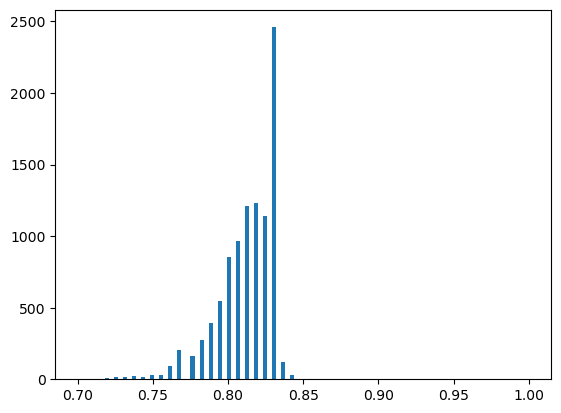

In [40]:
optimization_accuracy = [trial.values[0] for trial in study.trials]
plt.hist(optimization_accuracy, bins=100, range=(0.7, 1.0))[2]

## Post-Hyperparameter-Optimization Tasks: Metrics

Create the classifier with the best settings...

In [96]:
best_classifier = RandomForestClassifier(
    criterion="log_loss", 
    n_estimators=56, 
    max_depth=12, 
    min_samples_leaf=3,
    class_weight=class_weight
)
best_classifier.fit(x_train, y_train)

,n_estimators,56
,criterion,'log_loss'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Calculate accuracy for the different sets...

In [97]:
y_train_pred = best_classifier.predict(x_train)
y_valid_pred = best_classifier.predict(x_valid)
y_test_pred = best_classifier.predict(x_test)

print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.3%}")
print(f"Validation accuracy: {accuracy_score(y_valid, y_valid_pred):.3%}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.3%}")

Train accuracy: 82.353%
Validation accuracy: 76.875%
Test accuracy: 78.555%


Calculate precision, recall and F1 scores...

In [98]:
print(f"Train precision: {precision_score(y_train, y_train_pred):.3%}")
print(f"Validation precision: {precision_score(y_valid, y_valid_pred):.3%}")
print(f"Test precision: {precision_score(y_test, y_test_pred):.3%}")

print(f"Train recall: {recall_score(y_train, y_train_pred):.3%}")
print(f"Validation recall: {recall_score(y_valid, y_valid_pred):.3%}")
print(f"Test recall: {recall_score(y_test, y_test_pred):.3%}")

print(f"Train F1: {f1_score(y_train, y_train_pred):.3%}")
print(f"Validation F1: {f1_score(y_valid, y_valid_pred):.3%}")
print(f"Test F1: {f1_score(y_test, y_test_pred):.3%}")

Train precision: 71.429%
Validation precision: 68.852%
Test precision: 74.098%
Train recall: 83.333%
Validation recall: 70.000%
Test recall: 67.665%
Train F1: 76.923%
Validation F1: 69.421%
Test F1: 70.736%


Show ROC and PR curve...

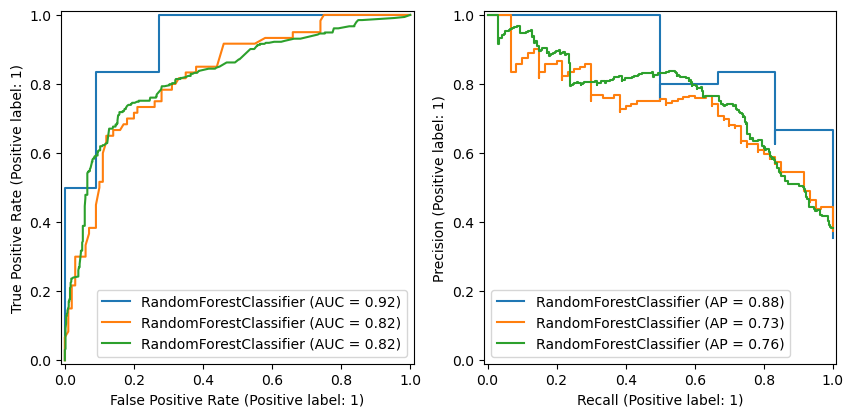

In [99]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(10, 20)
RocCurveDisplay.from_estimator(best_classifier, x_train, y_train, ax=ax[0])
RocCurveDisplay.from_estimator(best_classifier, x_valid, y_valid, ax=ax[0])
RocCurveDisplay.from_estimator(best_classifier, x_test, y_test, ax=ax[0])

PrecisionRecallDisplay.from_estimator(best_classifier, x_train, y_train, ax=ax[1])
PrecisionRecallDisplay.from_estimator(best_classifier, x_valid, y_valid, ax=ax[1])
PrecisionRecallDisplay.from_estimator(best_classifier, x_test, y_test, ax=ax[1])

## Calculating a Confusion Matrix

Using the best model, calculate the confusion matrix...

In [100]:
confusion_matrix(y_train, y_train_pred)

array([[9, 2],
       [1, 5]])

## Trying out Cross-Validation

Using the best classifier hyperparameter setup according to optuna, let's test out how it performs using 5-fold CV...

In [101]:
rfc = RandomForestClassifier(
    criterion="log_loss", 
    n_estimators=56, 
    max_depth=12, 
    min_samples_leaf=3,
    class_weight=class_weight
)
cross_validate(rfc, x_all, y_all, cv=5, scoring="accuracy")["test_score"]

array([0.79775281, 0.79213483, 0.83146067, 0.79213483, 0.83615819])

## Hunting for the Overfitting Phenomenon

Scan through the `n_estimators` parameter and observe the train/test performance...

Text(0.5, 1.0, 'Trying to Overfit a RandomForestClassifier on\nthe Titanic Dataset')

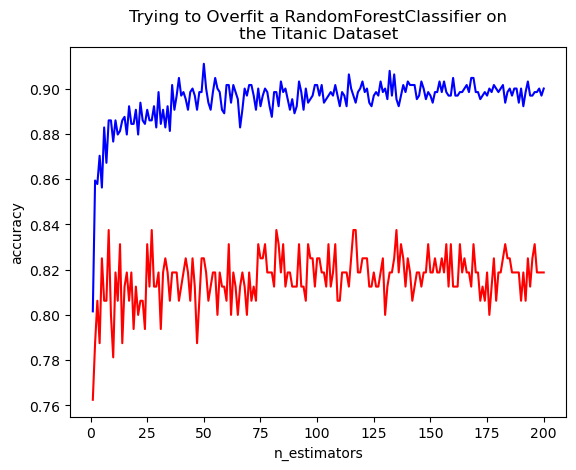

In [67]:
train_accuracies, test_accuracies = list(), list()
parameter_range = list(range(1, 201))
for parameter in parameter_range:
    
    current_classifier = RandomForestClassifier(
        criterion="log_loss", 
        n_estimators=56, 
        max_depth=12, 
        min_samples_leaf=3,
        class_weight=class_weight
    )
    current_classifier.fit(x_train, y_train)

    y_train_pred = current_classifier.predict(x_train)
    y_valid_pred = current_classifier.predict(x_valid)

    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    test_accuracies.append(accuracy_score(y_valid, y_valid_pred))

fig, ax = plt.subplots()
ax.plot(parameter_range, train_accuracies, color="blue")
ax.plot(parameter_range, test_accuracies, color="red")
ax.set_xlabel("n_estimators")
ax.set_ylabel("accuracy")
ax.set_title("Trying to Overfit a RandomForestClassifier on\nthe Titanic Dataset")

It seems that along the `n_estimators` parameter, this algorithm is robust and the test accuracy does not start to degrade, even for very deep forests. Let's try to observe this along the train/test split ratio, since that must produce the expected curve...

<Axes: title={'center': 'Trying to Overfit on\nthe Titanic Dataset'}, xlabel='test/train split ratio', ylabel='accuracy'>

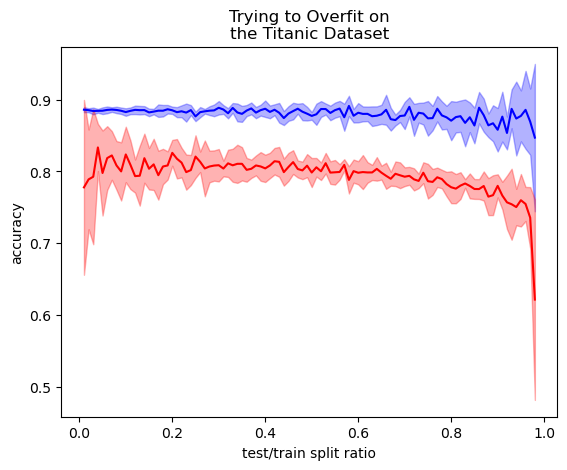

In [81]:
def tt_split_overfit(
    parameter_range: np.ndarray, 
    classifier: Any, 
    parallels: int
) -> Tuple[np.ndarray, np.ndarray]:

    train_accuracies, test_accuracies = list(), list()
    for parameter in parameter_range:
    
        train_accuracies_parallel, test_accuracies_parallel = list(), list()
    
        # Run multiple parallels for a single split ratio
        for parallel_idx in range(parallels):
    
            x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, test_size=parameter)
            current_classifier = clone(classifier)
            current_classifier.fit(x_train, y_train)
        
            y_train_pred = current_classifier.predict(x_train)
            y_test_pred = current_classifier.predict(x_test)
        
            train_accuracies_parallel.append(accuracy_score(y_train, y_train_pred))
            test_accuracies_parallel.append(accuracy_score(y_test, y_test_pred))
    
        # Calculate mean and std for the parallels
        current_train_accuracy_mean = np.mean(train_accuracies_parallel)
        current_train_accuracy_std = np.std(train_accuracies_parallel)
        current_test_accuracy_mean = np.mean(test_accuracies_parallel)
        current_test_accuracy_std = np.std(test_accuracies_parallel)
    
        train_accuracies.append([current_train_accuracy_mean, current_train_accuracy_std])
        test_accuracies.append([current_test_accuracy_mean, current_test_accuracy_std])
    
    train_accuracies = np.array(train_accuracies)
    test_accuracies = np.array(test_accuracies)

    return train_accuracies, test_accuracies

def plot_tt_split_overfit_results(train_accuracies: np.ndarray, test_accuracies: np.ndarray) -> plt.Axes:

    fig, ax = plt.subplots()
    ax.plot(parameter_range, train_accuracies[:, 0], color="blue")
    ax.plot(parameter_range, test_accuracies[:, 0], color="red")
    
    # Show +/-1 std ranges around the means
    ax.fill_between(
        parameter_range, 
        train_accuracies[:, 0] - train_accuracies[:, 1],
        train_accuracies[:, 0] + train_accuracies[:, 1],
        color="blue", alpha=0.3
    )
    ax.fill_between(
        parameter_range, 
        test_accuracies[:, 0] - test_accuracies[:, 1],
        test_accuracies[:, 0] + test_accuracies[:, 1],
        color="red", alpha=0.3
    )
    ax.set_xlabel("test/train split ratio")
    ax.set_ylabel("accuracy")
    ax.set_title("Trying to Overfit on\nthe Titanic Dataset")

    return ax

rfc = RandomForestClassifier(
    criterion="log_loss", 
    n_estimators=56, 
    max_depth=12, 
    min_samples_leaf=3,
    class_weight=class_weight
)
train_accuracies, test_accuracies = tt_split_overfit(np.arange(0.01, 0.99, 0.01), rfc, 10)
plot_tt_split_overfit_results(train_accuracies, test_accuracies)

This sort of works, but the phenomenon is still not clear; the accuracies are too noisy to spot the real accuracy maximum for the test set (red curve), even for 10 parallels. Also, the optimal test/train ratio is too far on the left, making it seem like that, optimally, the size of the test set should be 0. (Even though this is probably not true.) Let's try it on a classifier, which is more prone to overfit. A DecisionTreeClassifier should do it, since it is not of an ensemble type...

<Axes: title={'center': 'Trying to Overfit on\nthe Titanic Dataset'}, xlabel='test/train split ratio', ylabel='accuracy'>

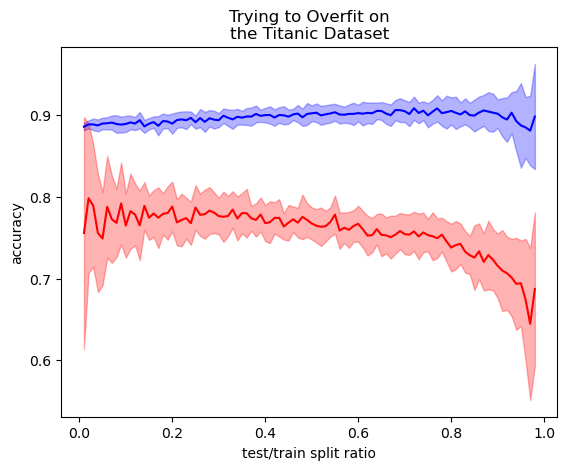

In [83]:
dtc = DecisionTreeClassifier(
    criterion="log_loss", 
    max_depth=12, 
    min_samples_leaf=3,
    class_weight=class_weight
)
train_accuracies, test_accuracies = tt_split_overfit(np.arange(0.01, 0.99, 0.01), dtc, 30)
plot_tt_split_overfit_results(train_accuracies, test_accuracies)

Still not the best.